In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.read_csv('text.csv')

In [ ]:
df.head(10)

,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,gave internship dmrg feeling distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thoroughly weary job take...,fear
5,beginning feel quite disheartened,sadness
6,would think whomever would lucky enough stay s...,love
7,fear ever feel delicious excitement christmas ...,joy
8,im forever taking tears eyes lie feel weird,surprise
9,still lose weight without feeling deprived,sadness


Each entry in this dataset consists of a text segment representing a Twitter message and a corresponding label indicating the predominant emotion conveyed. The emotions are classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5). Whether you're interested in sentiment analysis, emotion classification, or text mining, this dataset provides a rich foundation for exploring the nuanced emotional landscape within the realm of social media.


In [ ]:
df.columns

Index(['Unnamed: 0', 'text', 'label'], dtype='object')

In [ ]:
df.shape

(399057, 3)

In [ ]:
df.tail(10)

,Unnamed: 0,text,label
399047,399047,i feels that more strange matter has no the an...,5.0
399048,399048,i even feel like i ve satisfied the near endle...,1.0
399049,399049,i feel spiteful and i watch with something alm...,3.0
399050,399050,i ve met lately her wild livesex attitude make...,2.0
399051,399051,i feel very happy and i dont even have the tim...,1.0
399052,399052,i feel miserable and worthless on a daily basi...,0.0
399053,399053,i just couldnt settle i still and will not be ...,4.0
399054,399054,i feel so distressed when i think of what you ...,4.0
399055,399055,i feel my gluts aching intensely,0.0
399056,39905,NaN,NaN


In [ ]:
df.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
df

,text,label
0,i just feel really helpless and heavy hearted,4.0
1,ive enjoyed being able to slouch about relax a...,0.0
2,i gave up my internship with the dmrg and am f...,4.0
3,i dont know i feel so lost,0.0
4,i am a kindergarten teacher and i am thoroughl...,4.0
...,...,...
399052,i feel miserable and worthless on a daily basi...,0.0
399053,i just couldnt settle i still and will not be ...,4.0
399054,i feel so distressed when i think of what you ...,4.0
399055,i feel my gluts aching intensely,0.0


In [ ]:
df.duplicated().sum()

628

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.isna().sum()

text     1
label    1
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df.isna().sum()

text     0
label    0
dtype: int64

In [ ]:
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

df['label'] = df['label'].map(emotion_map)

In [ ]:
df.head(10)

,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sadness
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sadness
4,i am a kindergarten teacher and i am thoroughl...,fear
5,i was beginning to feel quite disheartened,sadness
6,i would think that whomever would be lucky eno...,love
7,i fear that they won t ever feel that deliciou...,joy
8,im forever taking some time out to have a lie ...,surprise
9,i can still lose the weight without feeling de...,sadness


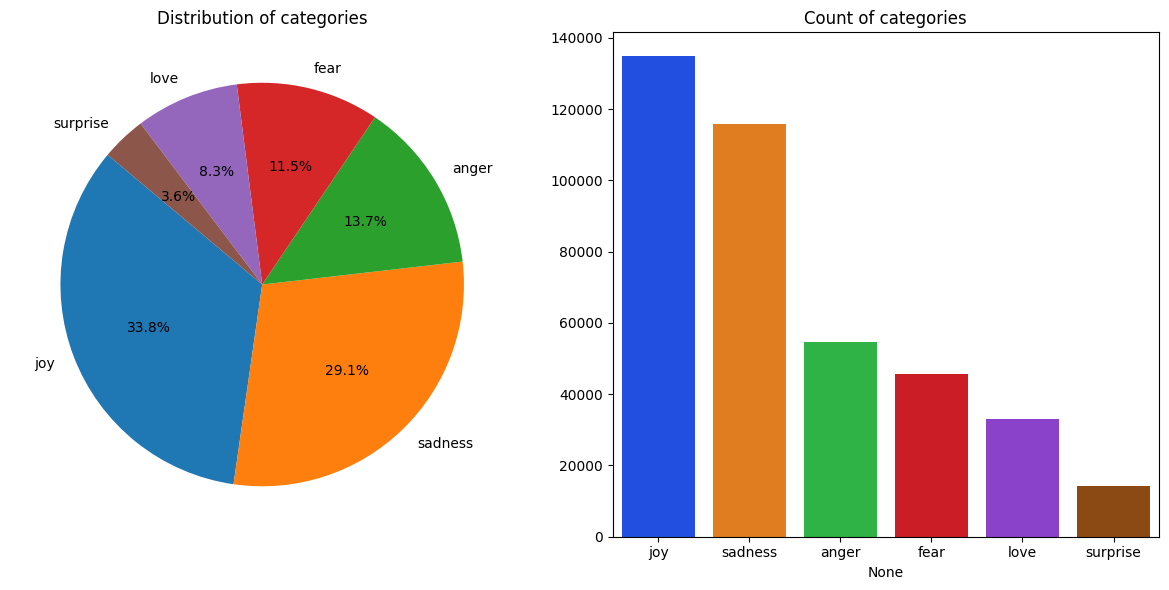

In [ ]:
count = df['label'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(12, 6) )
palette = sns.color_palette('bright', len(count) )
sns.set_palette(palette)
axs[0].pie(count,
           labels=count.index,
           autopct='%1.1f%%',
           startangle=140)

axs[0].set_title('Distribution of categories')
sns.barplot(x=count.index,
            y=count.values,
            ax=axs[1],
            palette=palette)
axs[1].set_title('Count of categories')

plt.tight_layout()
plt.show()

In [ ]:
# Define a dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [ ]:
def replace_chat_words(text):
  words = text.split()
  for i, word in enumerate(words):
    if word.upper() in chat_words:
      words[i] = chat_words[word.upper()]
  return ' '.join(words)

df['text'] = df['text'].apply(replace_chat_words)

In [ ]:
# remove all non-letter and non-whitespace characters
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

In [ ]:
df.head(20)

,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sadness
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sadness
4,i am a kindergarten teacher and i am thoroughl...,fear
5,i was beginning to feel quite disheartened,sadness
6,i would think that whomever would be lucky eno...,love
7,i fear that they won t ever feel that deliciou...,joy
8,im forever taking some Tears in my eyes out to...,surprise
9,i can still lose the weight without feeling de...,sadness


In [ ]:
# remove stop words
stop = stopwords.words('english')
# print(stop[:10])
df['text'] = df['text'].apply(lambda x: ' '.join(
    [word for word in x.split() if word not in (stop)]
))

df.head(20)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,gave internship dmrg feeling distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thoroughly weary job take...,fear
5,beginning feel quite disheartened,sadness
6,would think whomever would lucky enough stay s...,love
7,fear ever feel delicious excitement christmas ...,joy
8,im forever taking Tears eyes lie feel weird,surprise
9,still lose weight without feeling deprived,sadness


In [ ]:
# Lowercasing
df['text'] = df['text'].str.lower()
df['text'].head(20)

0                    feel really helpless heavy hearted
1     ive enjoyed able slouch relax unwind frankly n...
2               gave internship dmrg feeling distraught
3                                   dont know feel lost
4     kindergarten teacher thoroughly weary job take...
5                     beginning feel quite disheartened
6     would think whomever would lucky enough stay s...
7     fear ever feel delicious excitement christmas ...
8           im forever taking tears eyes lie feel weird
9            still lose weight without feeling deprived
10    try nice though get bitchy person phone window...
11    im feeling little like damaged tree roots litt...
12    officially graduated im feeling ecstatic thoug...
13    feel like jerk library students claim love scr...
14    feel portfolio demonstrates eager learn know b...
15    may biased next dependent life take care keep ...
16                                        feel terrific
17    miss others well feel wronged soon underst

In [ ]:
# Remove numbers
# Numbers have a little affect on sentiment
df['text'] = df['text'].str.replace(r'\d+', '', regex=True)
df.head(20)

,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,gave internship dmrg feeling distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thoroughly weary job take...,fear
5,beginning feel quite disheartened,sadness
6,would think whomever would lucky enough stay s...,love
7,fear ever feel delicious excitement christmas ...,joy
8,im forever taking tears eyes lie feel weird,surprise
9,still lose weight without feeling deprived,sadness


In [ ]:
# Remove white spaces
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)
df.head()

,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,gave internship dmrg feeling distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thoroughly weary job take...,fear


In [ ]:
# Remove special characters
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


In [ ]:
# Remove URLs
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


# TOP 20 WORDS FROM EACH LABEL

In [ ]:
love_texts = df[df['label'] == 'sadness']['text']

words = [word.lower() for text in love_texts for word in word_tokenize(text)]

In [ ]:
words[:10]

['ive',
 'enjoyed',
 'able',
 'slouch',
 'relax',
 'unwind',
 'frankly',
 'needed',
 'last',
 'weeks']

In [ ]:
def get_top_20_words(label):

  texts = df[df['label'] == label]['text']

  words = [word.lower() for text in texts for word in word_tokenize(text)]

  word_freq = Counter(words)

  top_20_words = dict(word_freq.most_common(20) )

  plt.figure(figsize=(12, 6))
  p = sns.barplot(x=list(top_20_words.keys()),
                  y = list(top_20_words.values()),
                  linewidth=2,
                  palette='magma')

  for container in p.containers:
    plt.bar_label(container,
                  label_type='edge',
                  position=(0.5, 0.5)
                  )

  plt.title(f"Top 20 Words Associated with {label.upper()}", fontsize=20, fontweight='bold')
  plt.xlabel('Words', fontsize=10)
  plt.ylabel('Frequency', fontsize=10)
  plt.xticks(rotation=80, fontsize=12,)
  plt.yticks(fontsize=12)
  plt.tight_layout()
  plt.show()

In [ ]:
df['label'].unique()

array(['fear', 'sadness', 'love', 'joy', 'surprise', 'anger'],
      dtype=object)

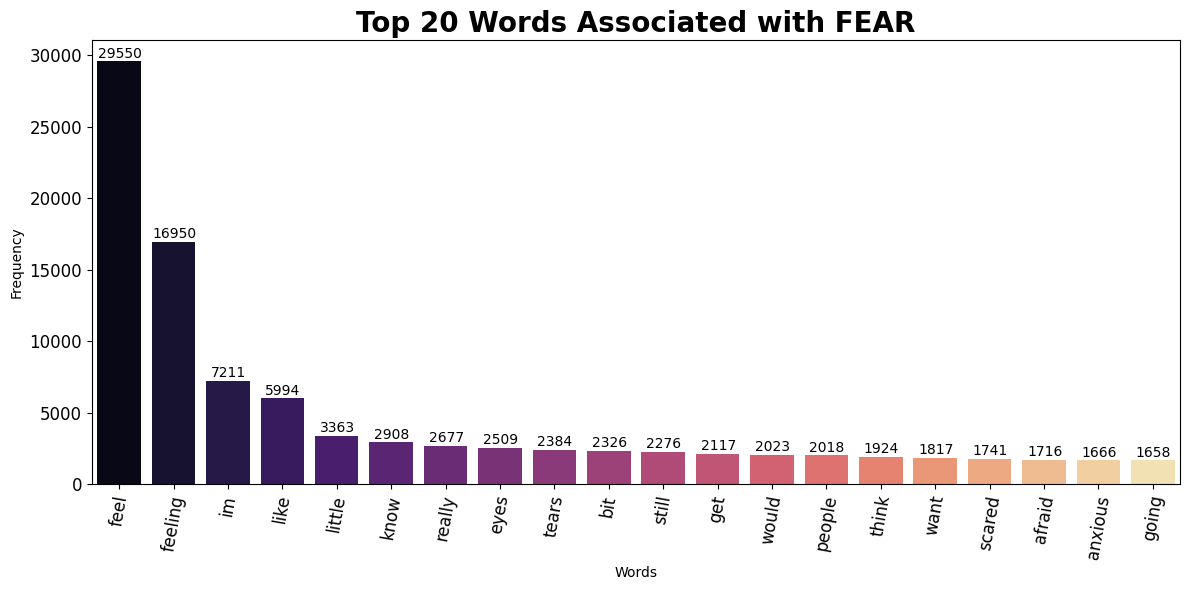

In [ ]:
get_top_20_words('fear')

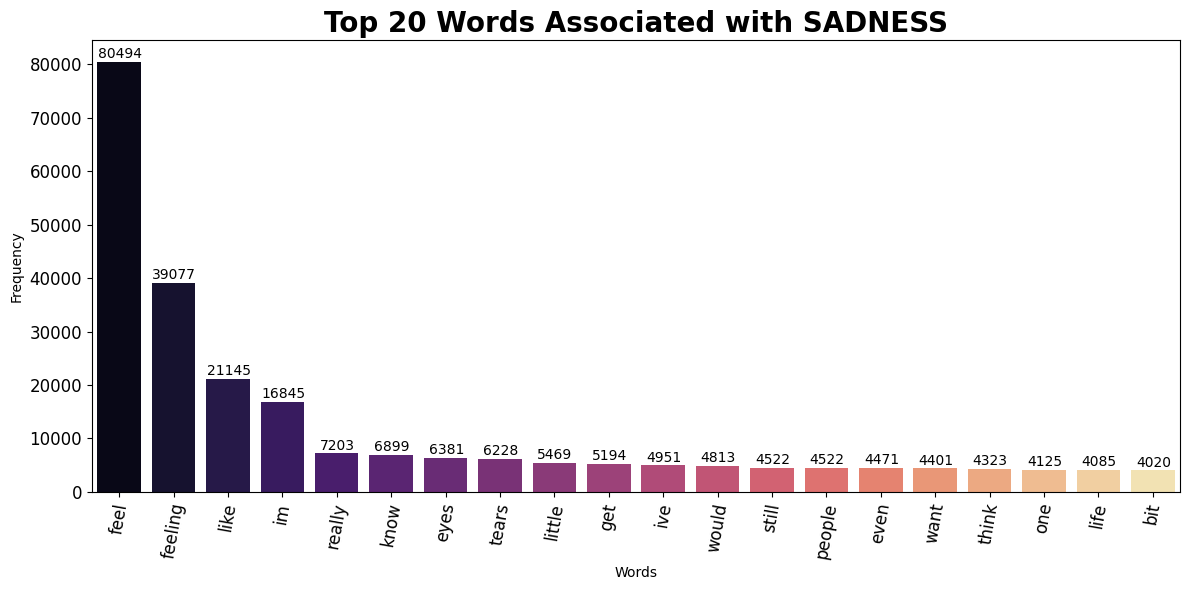

In [ ]:
get_top_20_words('sadness')

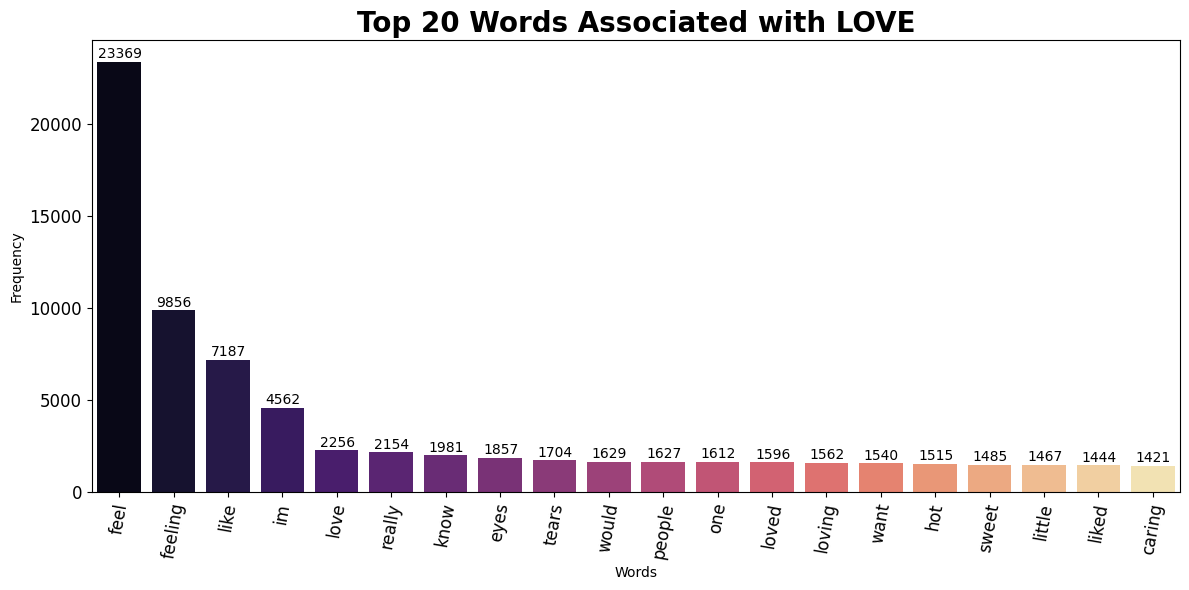

In [ ]:
get_top_20_words('love')

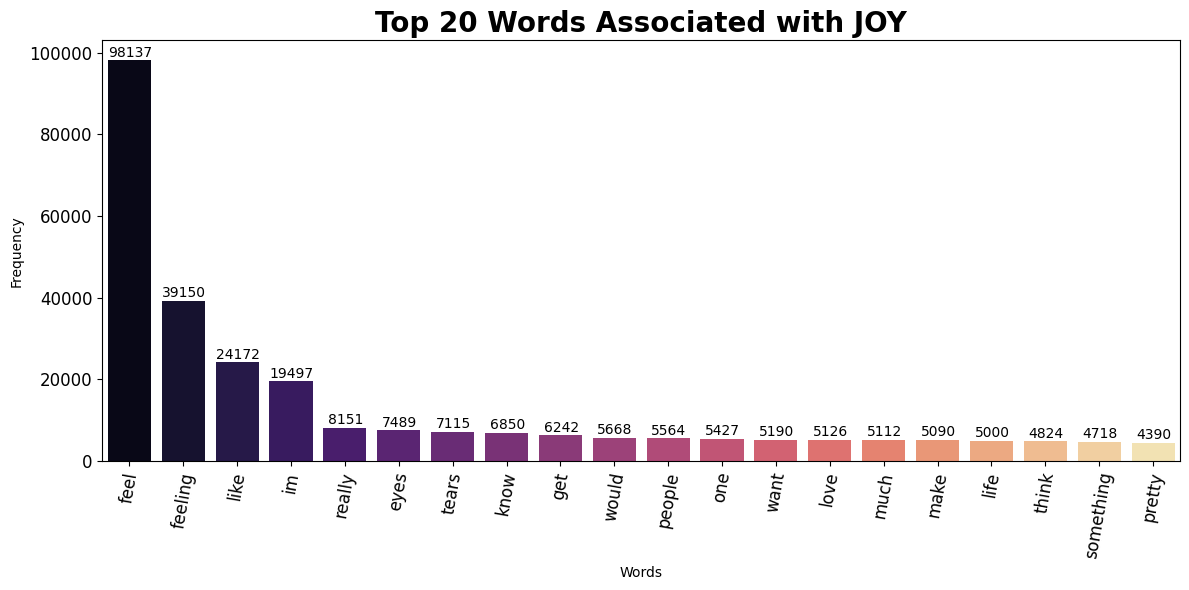

In [ ]:
get_top_20_words('joy')

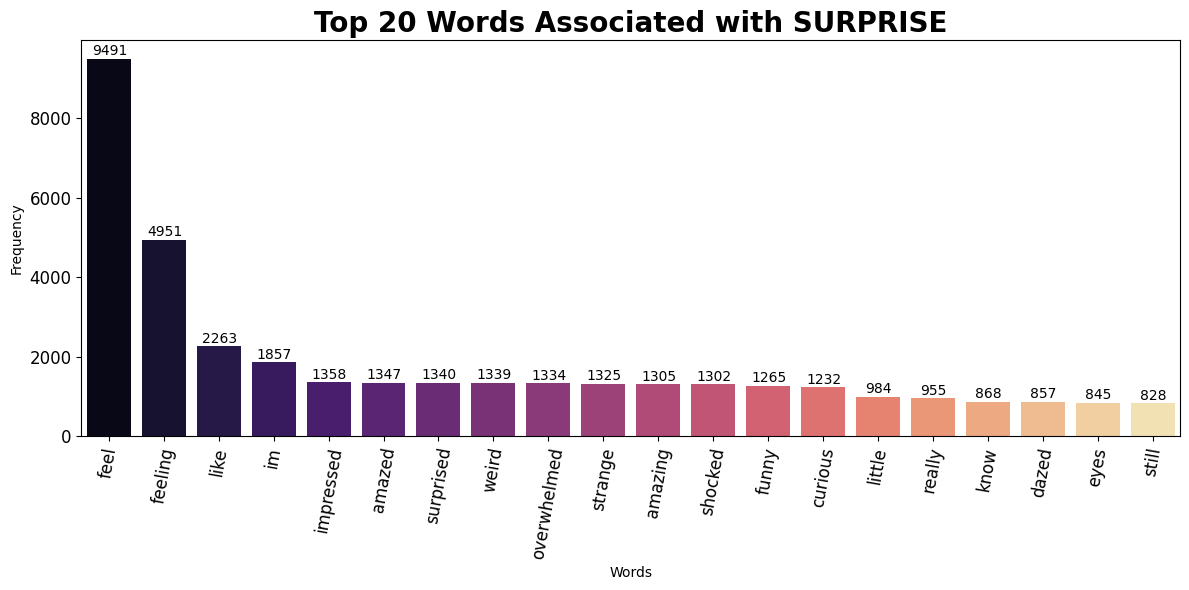

In [ ]:
get_top_20_words('surprise')

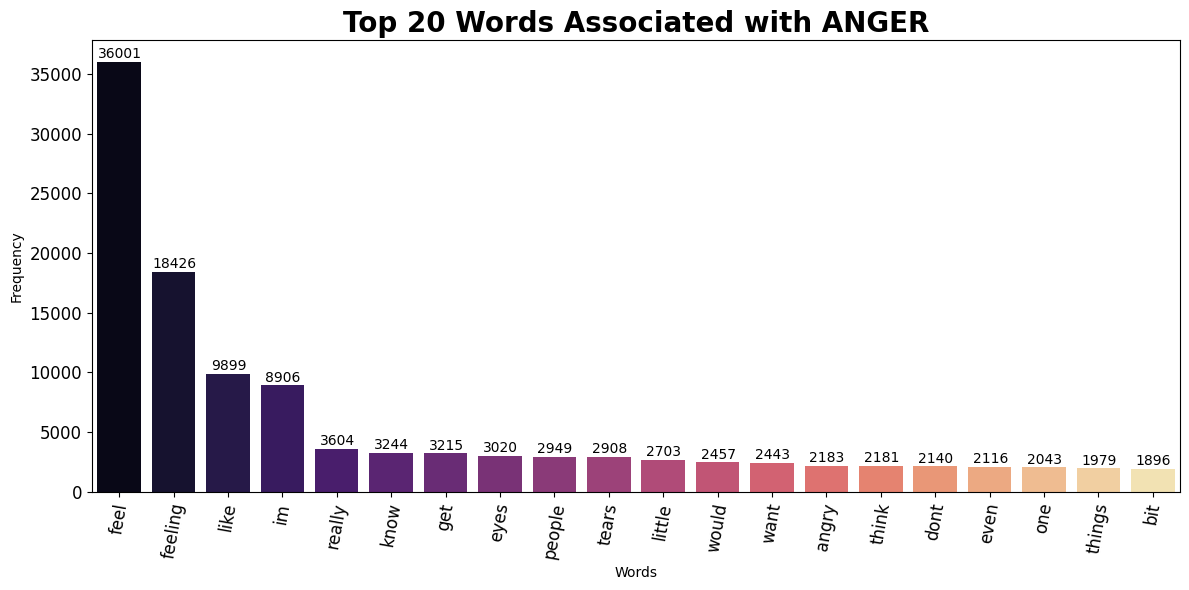

In [ ]:
get_top_20_words('anger')

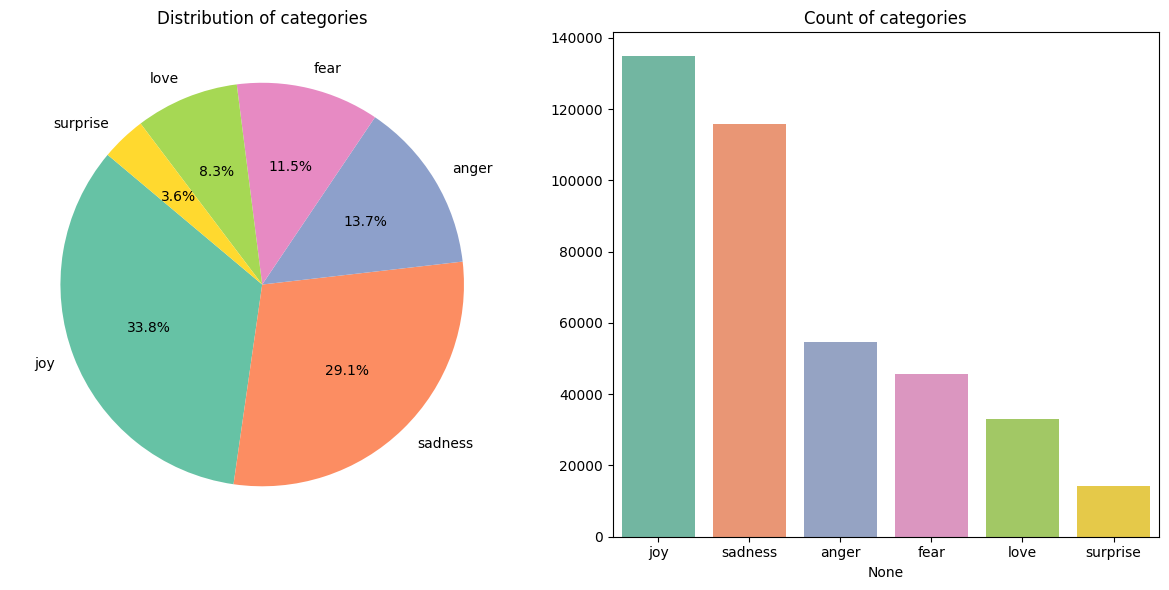

In [ ]:
count = df['label'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(12, 6) )
palette = sns.color_palette('Set2', len(count) )
sns.set_palette(palette)

axs[0].pie(count,
           labels=count.index,
           autopct='%1.1f%%',
           startangle=140)

axs[0].set_title('Distribution of categories')
sns.barplot(x=count.index,
            y=count.values,
            ax=axs[1],
            palette=palette)
axs[1].set_title('Count of categories')

plt.tight_layout()
plt.show()

# BiLSTM

In [ ]:
# Remap the labels back to numeric representation
label_mapping = {'sadness':0, 'joy':1,
                 'love':2, 'anger':3,
                 'fear':4,'surprise':5}

df['label'] = df['label'].map(label_mapping)

In [ ]:
df.head()

,text,label
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4


In [ ]:
from sklearn.model_selection import train_test_split

X, y = df['text'], df['label']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: (318742,), y_train: (318742,)
X_test: (79686,), y_test: (79686,)


In [ ]:
# Convert text into tokens
tokenizer = Tokenizer(num_words=60000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

In [ ]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Padding
maxlen = max(len(tokens) for tokens in X_train_sequences)
print(maxlen)

X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

80


# Model

In [ ]:
# Embedding Input Size
input_size = np.max(X_train_padded) + 1

model = Sequential()

model.add(Embedding(input_dim=input_size, # specifies the size of the vocabulary (e.g., 1000),
                    output_dim=100, # dimension of the dense embedding
                    input_shape=(80,))) # length of input sequences
# Bidirectional layers process the input sequence in both directions (forward and backward),
# which can capture more context in the sequence.
model.add(Bidirectional(LSTM(128)))
# Batch normalization normalizes the activations of the previous layer,
# which can help with training speed and stability.
model.add(BatchNormalization())
# Dropout is a regularization technique that randomly sets
# a fraction of input units to zero during training
model.add(Dropout(0.5))
# dense layer with 64 units and ReLU activation function
model.add(Dense(64, activation='relu'))
# another dropout layer for further regularization
model.add(Dropout(0.5))
# softmax output
model.add(Dense(6, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 80, 100)           6000000   
                                                                 
 bidirectional_7 (Bidirecti  (None, 256)               234496    
 onal)                                                           
                                                                 
 batch_normalization_6 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                16448     
                                                                 
 dropout_13 (Dropout)        (None, 64)              

In [ ]:
history = model.fit(X_train_padded, y_train,
                    epochs = 15,
                    batch_size = 32,
                    validation_data = (X_test_padded, y_test),
                    callbacks=[EarlyStopping(patience=3)])

Epoch 1/15
9961/9961 [==============================] - 1998s 200ms/step - loss: 0.2348 - accuracy: 0.9032 - val_loss: 0.0985 - val_accuracy: 0.9388
Epoch 2/15
2657/9961 [=======>......................] - ETA: 23:08 - loss: 0.1092 - accuracy: 0.9368

KeyboardInterrupt: 

In [ ]:
# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
model.evaluate(X_test_padded, y_test)

In [ ]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix with blue color
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Change 'Reds' to 'Blues' for blue color
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()